In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import re
import random
from scipy.sparse import hstack  # To combine sparse matrices
from wordcloud import WordCloud

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from imblearn.over_sampling import RandomOverSampler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import warnings
warnings.filterwarnings("ignore")

In [4]:
df = pd.read_csv("Combined Data.csv")
df

,Unnamed: 0,statement,status
0,0,oh my gosh,Anxiety
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,3,I've shifted my focus to something else but I'...,Anxiety
4,4,"I'm restless and restless, it's been a month n...",Anxiety
...,...,...,...
53038,53038,Nobody takes me seriously I’ve (24M) dealt wit...,Anxiety
53039,53039,"selfishness ""I don't feel very good, it's lik...",Anxiety
53040,53040,Is there any way to sleep better? I can't slee...,Anxiety
53041,53041,"Public speaking tips? Hi, all. I have to give ...",Anxiety


In [5]:
df = df.drop(df.columns[0], axis=1)
df

,statement,status
0,oh my gosh,Anxiety
1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,I've shifted my focus to something else but I'...,Anxiety
4,"I'm restless and restless, it's been a month n...",Anxiety
...,...,...
53038,Nobody takes me seriously I’ve (24M) dealt wit...,Anxiety
53039,"selfishness ""I don't feel very good, it's lik...",Anxiety
53040,Is there any way to sleep better? I can't slee...,Anxiety
53041,"Public speaking tips? Hi, all. I have to give ...",Anxiety


In [6]:
df.describe()

,statement,status
count,52681,53043
unique,51073,7
top,what do you mean?,Normal
freq,22,16351


In [7]:
df.isnull().sum()

statement    362
status         0
dtype: int64

In [8]:
df = df.dropna()
df.isnull().sum()

statement    0
status       0
dtype: int64

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 52681 entries, 0 to 53042
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   statement  52681 non-null  object
 1   status     52681 non-null  object
dtypes: object(2)
memory usage: 1.2+ MB


In [10]:
df.status.value_counts()

status
Normal                  16343
Depression              15404
Suicidal                10652
Anxiety                  3841
Bipolar                  2777
Stress                   2587
Personality disorder     1077
Name: count, dtype: int64

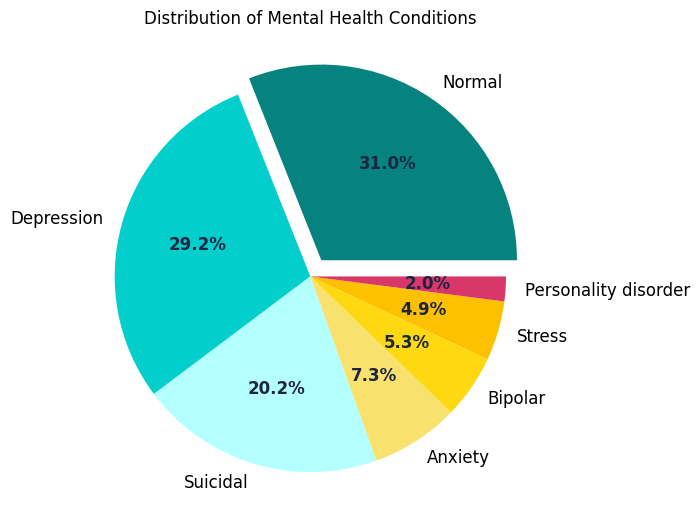

In [11]:
status_counts = df['status'].value_counts()
labels = status_counts.index

colors = ['#06837f', '#02cecb', '#b4ffff', '#f8e16c', '#fed811', '#fdc100', '#d9366a']

plt.figure(figsize=(7, 7))
wedges, texts, autotexts = plt.pie(status_counts, labels=labels, autopct='%1.1f%%',
        textprops=dict(fontsize=12), explode=[0.1,0,0,0,0,0,0], colors=colors)

for autotext in autotexts:
    autotext.set_color('#1c2541')
    autotext.set_weight('bold')
    
plt.title("Distribution of Mental Health Conditions")    
plt.tight_layout()
plt.show()

### Normal, Depression, and Suicidal states have the most samples in the dataset

In [12]:
random_statements = df.groupby('status')['statement'].apply(lambda x: x.sample(n=1).iloc[0])

for status, statement in random_statements.items():
    print(f"Status: {status}")
    print(f"Statement: {statement}\n")

Status: Anxiety
Statement: Can looking at screens too much permanently damage your eyesight? I know this seems ironic since I'm looking at a screen while typing this, but I've been concerned for a while that staring at my computer and phone screen too much could be permanently damaging my eyesight. I don't notice any changes as far as being able to read words from far away or my vision being blurry, but I do notice that I now see auras and halos around lights, such as headlights, when I'm driving, and I'm not sure if that's normal. Is there any evidence that looking at screens too much can permanently damage your eyesight?

Status: Bipolar
Statement: Bipolar and Relationships Has anyone else’s bipolar wrecked their relationship? I have bipolar 1 with psychotic features and I found out about it a year and a half ago. I also was also very recently diagnosed with C-PTSD due to an abusive childhood. I had a partner that I absolutely adored but after a huge life stressor I started to experi

In [13]:
df['num_of_characters'] = df['statement'].str.len()
df['num_of_sentences'] = df['statement'].apply(lambda x: len(nltk.sent_tokenize(x)))

description = df[['num_of_characters', 'num_of_sentences']].describe()

print(description)

       num_of_characters  num_of_sentences
count       52681.000000      52681.000000
mean          578.713863          6.280215
std           846.269078         10.688388
min             2.000000          1.000000
25%            80.000000          1.000000
50%           317.000000          3.000000
75%           752.000000          8.000000
max         32759.000000       1260.000000


In [14]:
df[df['num_of_characters'] > 10000]

,statement,status,num_of_characters,num_of_sentences
7851,So introduction I guess.. my name is Michael a...,Depression,10679,136
9416,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...,Suicidal,25302,1
9504,"Hello everyone,I rarely post on Reddit but.......",Depression,11163,139
10834,I have only 1 person I can somewhat open to bu...,Suicidal,27390,237
11537,"The title is not meant to discourage others, b...",Depression,12304,155
11581,I no longer know what else to do but write thi...,Depression,13530,140
11636,And has life gotten better?&amp;#x200B;No. Eve...,Depression,12819,96
11831,Sorry this is long but I doubt anyone will eve...,Depression,11122,155
13293,I cannot TAKE IT ANYMORE. I cannot TAKE IT ANY...,Suicidal,32759,1260
18215,I am someone living in Turkey. My age is proba...,Suicidal,10219,180


In [15]:
df.rename(columns={'statement': 'original_statement'}, inplace=True)  

df['statement']=df['original_statement'].str.lower()
df.head()

,original_statement,status,num_of_characters,num_of_sentences,statement
0,oh my gosh,Anxiety,10,1,oh my gosh
1,"trouble sleeping, confused mind, restless hear...",Anxiety,64,2,"trouble sleeping, confused mind, restless hear..."
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,78,2,"all wrong, back off dear, forward doubt. stay ..."
3,I've shifted my focus to something else but I'...,Anxiety,61,1,i've shifted my focus to something else but i'...
4,"I'm restless and restless, it's been a month n...",Anxiety,72,2,"i'm restless and restless, it's been a month n..."


In [16]:
def remove_patterns(text):
    # Remove URLs
    text = re.sub(r'http[s]?://\S+', '', text)
    # Remove markdown-style links
    text = re.sub(r'\[.*?\]\(.*?\)', '', text)
    # Remove handles (that start with '@')
    text = re.sub(r'@\w+', '', text)
    # Remove punctuation and other special characters
    text = re.sub(r'[^\w\s]', '', text)
    return text.strip()

# Apply the function to the 'statement' column
df['statement'] = df['statement'].apply(remove_patterns)
df.head()

,original_statement,status,num_of_characters,num_of_sentences,statement
0,oh my gosh,Anxiety,10,1,oh my gosh
1,"trouble sleeping, confused mind, restless hear...",Anxiety,64,2,trouble sleeping confused mind restless heart ...
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,78,2,all wrong back off dear forward doubt stay in ...
3,I've shifted my focus to something else but I'...,Anxiety,61,1,ive shifted my focus to something else but im ...
4,"I'm restless and restless, it's been a month n...",Anxiety,72,2,im restless and restless its been a month now ...


In [17]:
df['tokens'] = df['statement'].apply(word_tokenize)
df.head()

,original_statement,status,num_of_characters,num_of_sentences,statement,tokens
0,oh my gosh,Anxiety,10,1,oh my gosh,"[oh, my, gosh]"
1,"trouble sleeping, confused mind, restless hear...",Anxiety,64,2,trouble sleeping confused mind restless heart ...,"[trouble, sleeping, confused, mind, restless, ..."
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,78,2,all wrong back off dear forward doubt stay in ...,"[all, wrong, back, off, dear, forward, doubt, ..."
3,I've shifted my focus to something else but I'...,Anxiety,61,1,ive shifted my focus to something else but im ...,"[ive, shifted, my, focus, to, something, else,..."
4,"I'm restless and restless, it's been a month n...",Anxiety,72,2,im restless and restless its been a month now ...,"[im, restless, and, restless, its, been, a, mo..."


In [18]:
lemmatizer = WordNetLemmatizer()

def lemmatize_tokens(tokens):
    return ' '.join(lemmatizer.lemmatize(str(token)) for token in tokens)

df['tokens_lemmatized'] = df['tokens'].apply(lemmatize_tokens)

df.head()

,original_statement,status,num_of_characters,num_of_sentences,statement,tokens,tokens_lemmatized
0,oh my gosh,Anxiety,10,1,oh my gosh,"[oh, my, gosh]",oh my gosh
1,"trouble sleeping, confused mind, restless hear...",Anxiety,64,2,trouble sleeping confused mind restless heart ...,"[trouble, sleeping, confused, mind, restless, ...",trouble sleeping confused mind restless heart ...
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,78,2,all wrong back off dear forward doubt stay in ...,"[all, wrong, back, off, dear, forward, doubt, ...",all wrong back off dear forward doubt stay in ...
3,I've shifted my focus to something else but I'...,Anxiety,61,1,ive shifted my focus to something else but im ...,"[ive, shifted, my, focus, to, something, else,...",ive shifted my focus to something else but im ...
4,"I'm restless and restless, it's been a month n...",Anxiety,72,2,im restless and restless its been a month now ...,"[im, restless, and, restless, its, been, a, mo...",im restless and restless it been a month now b...


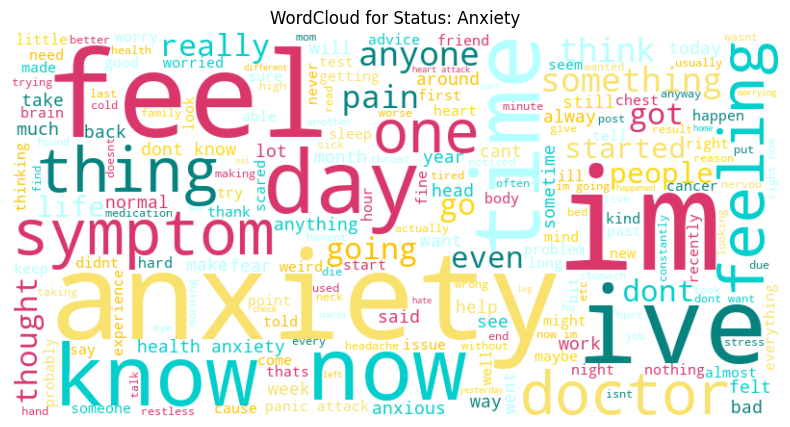

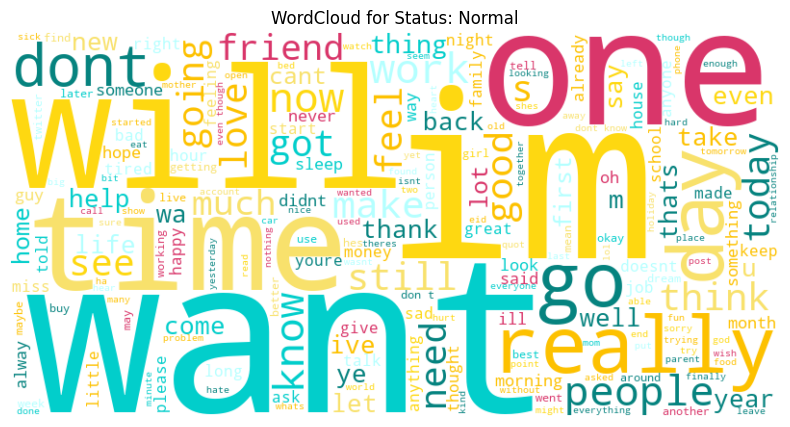

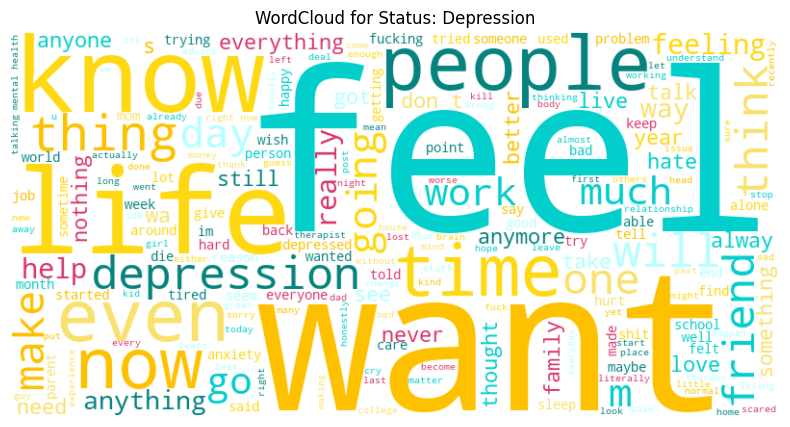

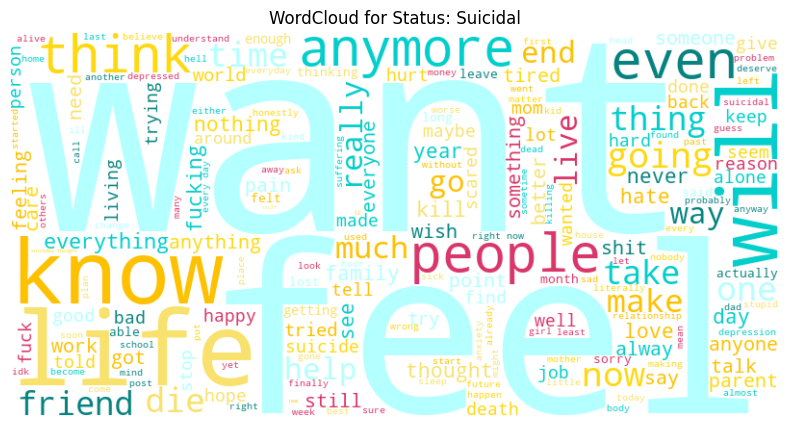

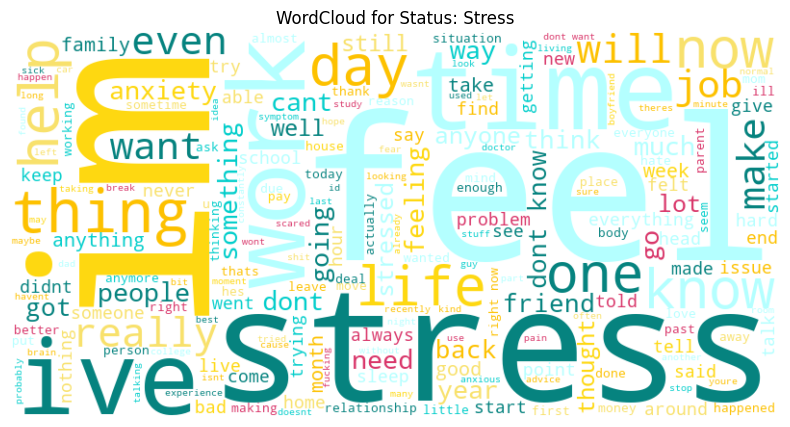

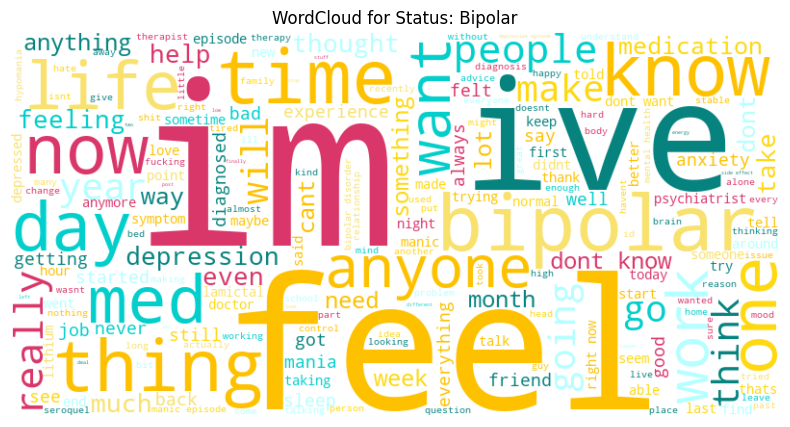

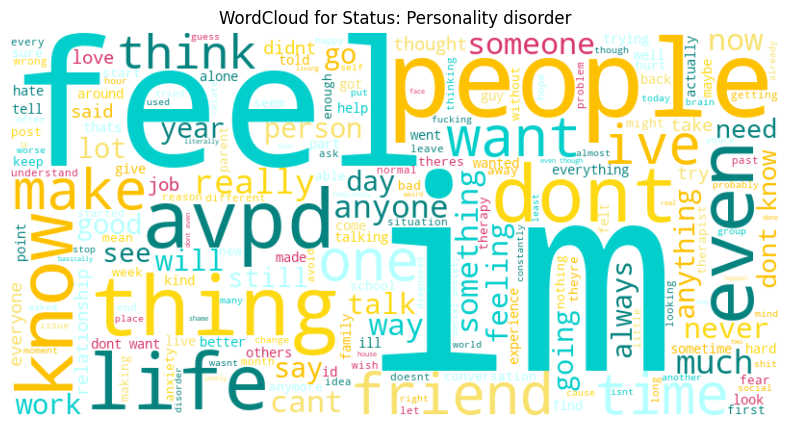

In [19]:
statuses = df['status'].unique()

# Define a color function
def color_func(word, font_size, position, orientation, random_state=101, **kwargs):
    return random.choice(colors)

# Generate and plot the WordCloud for each category
for status in statuses:
    # Filter the tokens data for the current status
    tokens_data = ' '.join(df[df['status'] == status]['tokens'].dropna().apply(lambda x: ' '.join(x)).tolist())

    # Generate the WordCloud
    wordcloud = WordCloud(width=800, height=400, background_color='white', color_func=color_func).generate(tokens_data)
    
    # Plot the WordCloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')  # Turn off axis
    plt.title(f'WordCloud for Status: {status}')
    plt.show()

In [20]:
X = df[['tokens_lemmatized', 'num_of_characters', 'num_of_sentences']]
y = df['status']

In [21]:
lbl_enc = LabelEncoder()
y = lbl_enc.fit_transform(y.values)

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

In [23]:
# 1. Initialize TF-IDF Vectorizer and fit/transform on the 'tokens' column
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=50000)
X_train_tfidf = vectorizer.fit_transform(X_train['tokens_lemmatized'])
X_test_tfidf = vectorizer.transform(X_test['tokens_lemmatized'])

# 2. Extract numerical features
X_train_num = X_train[['num_of_characters', 'num_of_sentences']].values
X_test_num = X_test[['num_of_characters', 'num_of_sentences']].values

# 3. Combine TF-IDF features with numerical features
X_train_combined = hstack([X_train_tfidf, X_train_num])
X_test_combined = hstack([X_test_tfidf, X_test_num])

print('Number of feature words: ', len(vectorizer.get_feature_names_out()))

Number of feature words:  50000


In [24]:
X_train_combined.shape

(42144, 50002)

In [25]:
ros = RandomOverSampler(random_state=101)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_combined, y_train)

In [26]:
X_train_resampled.shape

(91742, 50002)

In [32]:
import xgboost as xgb
from sklearn import metrics

# Initialize the XGBoost classifier and specify GPU usage
model = xgb.XGBClassifier(
                        n_estimators=100,
                        use_label_encoder=False,
                        tree_method='hist',  # Use CPU histogram method
                        predictor='cpu_predictor',
                        random_state=0
)

# Train the model (fitting) on resampled data
model.fit(X_train_resampled, y_train_resampled)

# Predict on the test data
Y_pred = model.predict(X_test_combined)

# Evaluate accuracy
accuracy = metrics.accuracy_score(y_test, Y_pred) * 100
percent = f"{accuracy:.2f}"
print("The model is providing %s percent accurate result." % percent)

The model is providing 78.94 percent accurate result.


In [33]:
labels = lbl_enc.classes_
conf_matrix = confusion_matrix(y_test, Y_pred)
print(classification_report(y_test, Y_pred, target_names=labels))

                      precision    recall  f1-score   support

             Anxiety       0.81      0.85      0.83       768
             Bipolar       0.82      0.83      0.82       566
          Depression       0.81      0.66      0.73      3050
              Normal       0.92      0.91      0.91      3237
Personality disorder       0.64      0.71      0.67       202
              Stress       0.59      0.81      0.68       530
            Suicidal       0.67      0.76      0.71      2184

            accuracy                           0.79     10537
           macro avg       0.75      0.79      0.76     10537
        weighted avg       0.80      0.79      0.79     10537



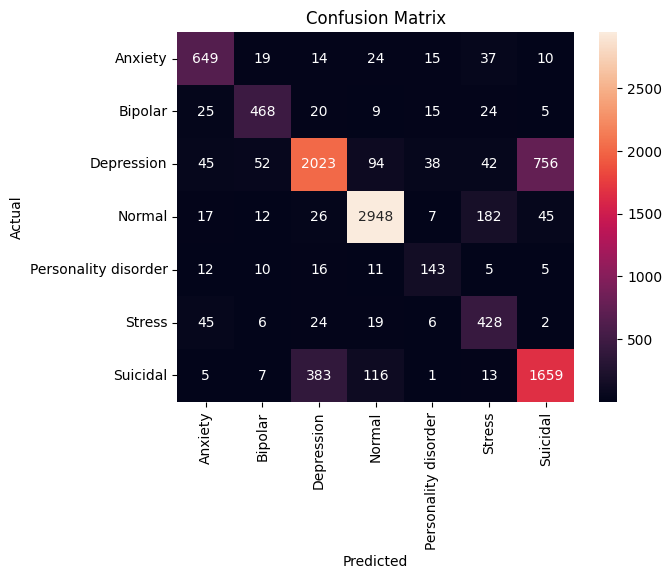

In [34]:
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')  # Label for x-axis
plt.ylabel('Actual')     # Label for y-axis
plt.title('Confusion Matrix')  # Title for the heatmap
plt.show()  # Display the heatmap

## 'Normal' state is most accurately predicted with an F1-score of 91%, followed by Anxiety at 83%